## LLM Misinformation Analysis

In this project ...

#### Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from model import *

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Initializing Data

In [5]:
# upload datasets
fake = pd.read_csv("Data\Fake.csv")
fake_df = pd.DataFrame(fake)

real = pd.read_csv("Data\True.csv")
real_df = pd.DataFrame(real)

fake_df['label'] = 1
real_df['label'] = 0

combined_df = pd.concat([fake_df, real_df], axis=0).reset_index(drop=True)
combined_df

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0


#### Data Cleaning

In [6]:
# Preprocess
required_cols = ['text', 'title', 'subject']

# If 'text' column doesn't exist but 'content' does, rename it
if 'text' not in combined_df.columns and 'content' in combined_df.columns:
    combined_df.rename(columns={'content': 'text'}, inplace=True)

# Ensure we have text content to work with
if 'text' not in combined_df.columns:
    # If no text column, try to use title as text
    if 'title' in combined_df.columns:
        combined_df['text'] = combined_df['title']
    else:
        raise ValueError("Neither 'text' nor 'title' columns found in dataset")

# Drop rows with missing text
combined_df = combined_df.dropna(subset=['text'])

# Shuffle the data
df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True) 
df

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0
...,...,...,...,...,...
44893,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,,politics,"Mar 27, 2017",1
44894,PM May seeks to ease Japan's Brexit fears duri...,LONDON/TOKYO (Reuters) - British Prime Ministe...,worldnews,"August 29, 2017",0
44895,Merkel: Difficult German coalition talks can r...,BERLIN (Reuters) - Chancellor Angela Merkel sa...,worldnews,"November 16, 2017",0
44896,Trump Stole An Idea From North Korean Propaga...,Jesus f*cking Christ our President* is a moron...,News,"July 14, 2017",1


#### Data Pre-Processing/Feature Extraction and Selection

In [7]:
# Data pre-processing
stop_words = set(stopwords.words('english'))
# Strip words to its base form 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Fill nulls and combine title and text
df['text'] = df['text'].fillna('')
df['title'] = df['title'].fillna('')
df['content'] = df['title'] + ' ' + df['text']
df['cleaned_text'] = df['content'].apply(clean_text)

In [8]:
# Feature Extraction
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text'])
y = df['label']

#### Implementing a Random Forest Classifier

In [11]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4284
           1       1.00      1.00      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



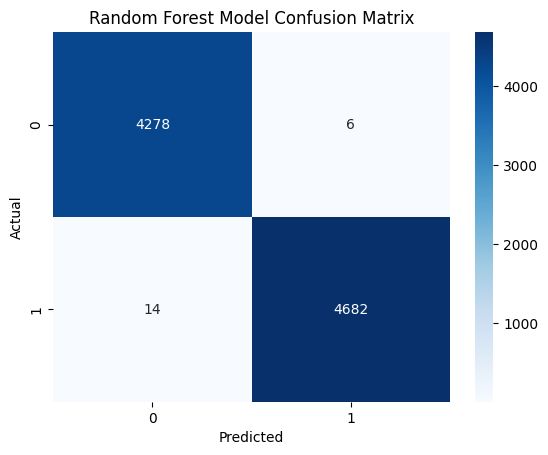

In [14]:
rf_cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Implementing a Logistic Regression (Classifier)

In [19]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

import time 

time.sleep(52)
y_pred_lr = lr_model.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4284
           1       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



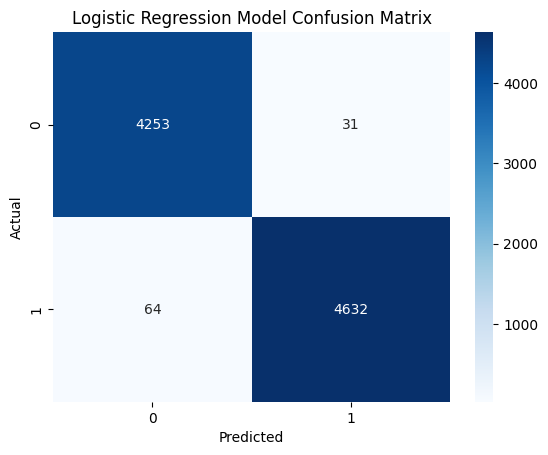

In [17]:
lr_cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Implementing new data